# Тест кластеризации

## imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

## reading data files

In [2]:
# YOUR DATA DIRECTORY HERE
data_dir = '/media/arrteom/3923b309-fef1-47f0-a74c-cd259de5b45b/PAMAP2_Dataset/PAMAP2_Dataset/' 
data_path = os.path.join(data_dir, 'pamap_small.csv')

In [3]:
df_init = pd.read_csv(data_path)
df_init = df_init[df_init.activityID <= 6]
df_init.shape

(97596, 41)

In [4]:

print(f'full df shape {df_init.shape}')
df_train, df_test = train_test_split(df_init, test_size=0.3, random_state=42) # do not change
del df_init
print(f'{df_train.shape = }, {df_test.shape = }')

full df shape (97596, 41)
df_train.shape = (68317, 41), df_test.shape = (29279, 41)


## corr

<Axes: >

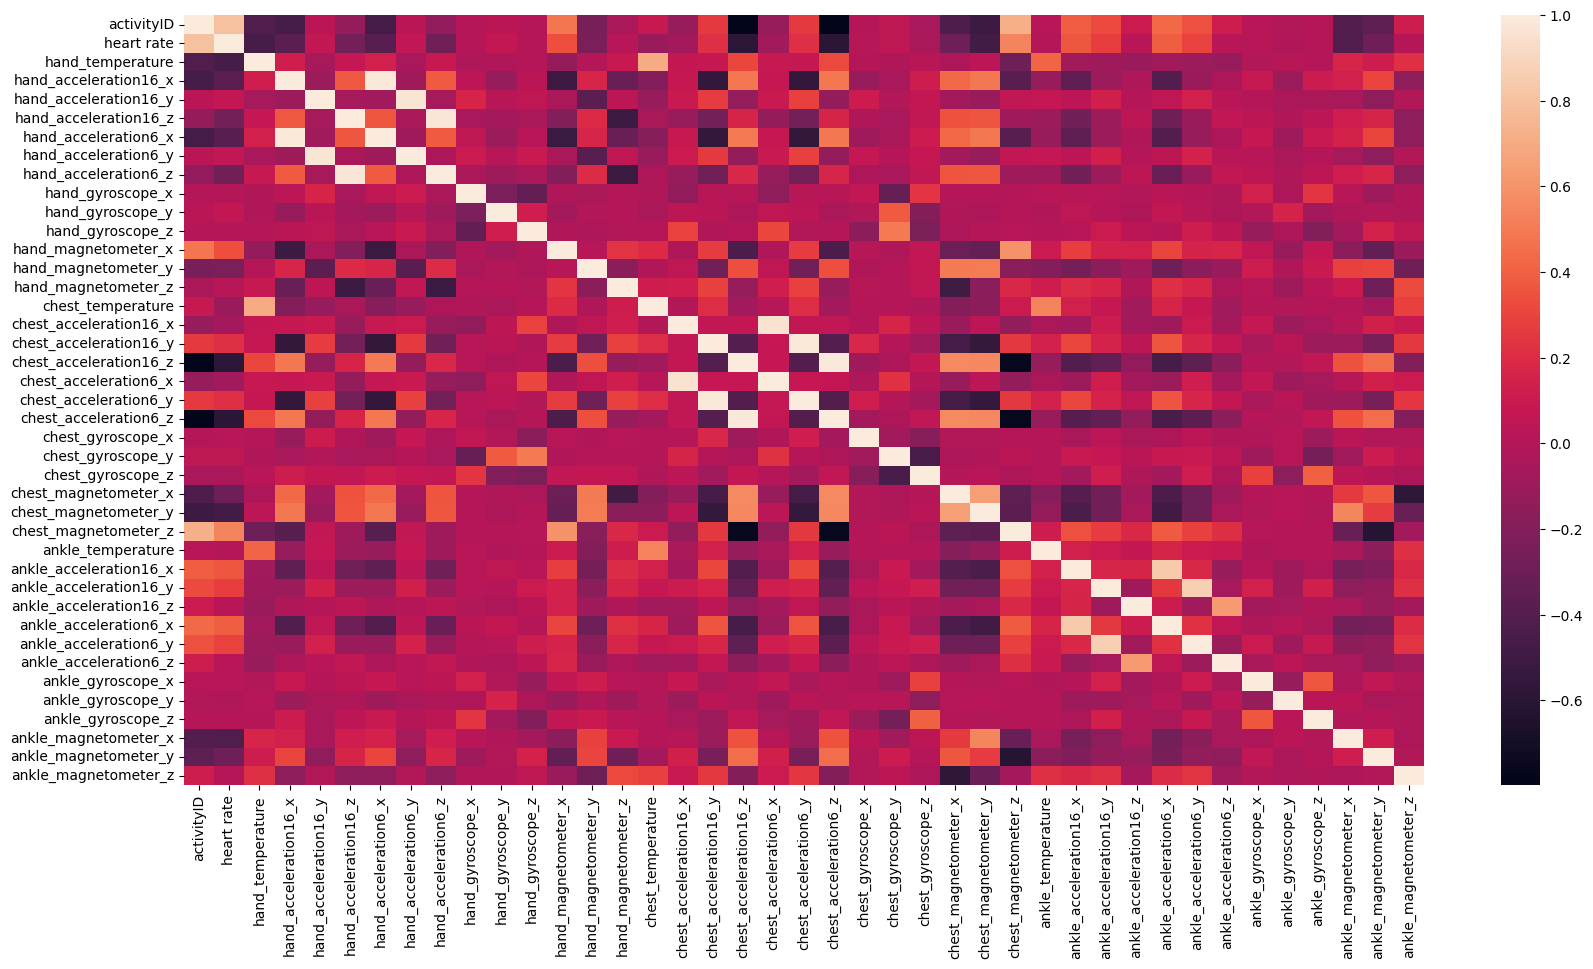

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
sns.heatmap(df_train.corr())

In [6]:
drop_thr = 0.5

corr_arr = np.tril(np.abs(np.array(df_train.corr()) - np.eye(df_train.corr().shape[0])))
cols_to_drop = [col for col, maxcorr in zip(df_train.columns, corr_arr.max(axis=1)) if maxcorr > drop_thr]
cols_to_drop


['heart rate',
 'hand_acceleration6_x',
 'hand_acceleration6_y',
 'hand_acceleration6_z',
 'hand_magnetometer_x',
 'hand_magnetometer_z',
 'chest_temperature',
 'chest_acceleration16_y',
 'chest_acceleration16_z',
 'chest_acceleration6_x',
 'chest_acceleration6_y',
 'chest_acceleration6_z',
 'chest_magnetometer_x',
 'chest_magnetometer_y',
 'chest_magnetometer_z',
 'ankle_temperature',
 'ankle_acceleration6_x',
 'ankle_acceleration6_y',
 'ankle_acceleration6_z',
 'ankle_magnetometer_x',
 'ankle_magnetometer_y',
 'ankle_magnetometer_z']

In [7]:
df_train.drop(columns=cols_to_drop, inplace=True)

## preprocessing
тут стоит в общих чертах написать про то почему такой препроцессинг

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())


In [9]:
X_train = pipe.fit_transform(df_train.drop(columns='activityID'))
y_train = df_train['activityID']

## PCA

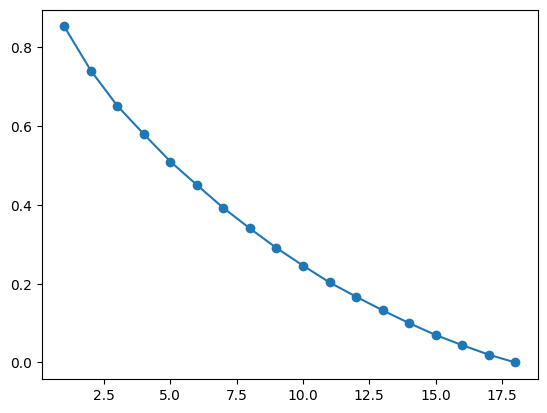

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_for_dimention_selection = PCA(n_components=X_train.shape[1])
pca_for_dimention_selection.fit(X_train)
explained_variance_cumsum = pca_for_dimention_selection.explained_variance_.cumsum()
explained_variance_sum = pca_for_dimention_selection.explained_variance_.sum()
plt.plot(range(1, explained_variance_cumsum.shape[0] + 1),
         (explained_variance_sum - explained_variance_cumsum) / explained_variance_sum,
         marker='o')

In [11]:
pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), PCA(n_components=15))
X_train = pipe.fit_transform(df_train.drop(columns='activityID'))
y_train = df_train['activityID']

## KMeans

### cross validation param selection
тут немного про то в каких границах подбирали какие параметры и почему

In [120]:
from sklearn.cluster import KMeans


param_grid = {
    'n_clusters': list(range(2, 8)),  # тут нужно осмысленно выборать параметры
    'n_init': [10]
}
grid_search = GridSearchCV(KMeans(), param_grid, cv=5, scoring='adjusted_mutual_info_score')

In [121]:
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)

0.4216779050492173


In [122]:
print(grid_search.best_params_)

{'n_clusters': 7, 'n_init': 10}


### model train

In [123]:
full_model = KMeans(**grid_search.best_params_).fit(X_train, y_train)

### metrics

In [124]:
X_test = pipe.transform(df_test.drop(columns=['activityID'] + cols_to_drop))
y_test = df_test['activityID']
preds = full_model.predict(X_test)

In [125]:
train_armi = adjusted_mutual_info_score(y_train, full_model.predict(X_train))
test_ari = adjusted_rand_score(y_test, preds)
test_armi = adjusted_mutual_info_score(y_test, preds)

print(f'{test_ari = :.4f}, {test_armi = :.4f}, {train_armi = :.4f}')

test_ari = 0.3268, test_armi = 0.4211, train_armi = 0.4210


In [126]:
from sklearn.metrics import homogeneity_completeness_v_measure

homogeneity_completeness_v_measure(y_test, preds)

(0.3978989216335701, 0.44759011692496875, 0.42128429047861127)

### clusters visualized

In [132]:
viz_pca = PCA(n_components=3)
df_viz = pd.DataFrame(viz_pca.fit_transform(X_test))

df_viz['true_label'] = np.array(y_test)
df_viz['pred_label'] = np.array(preds)
# df_viz = pd.DataFrame

In [134]:
df_viz

,0,1,2,true_label,pred_label
0,-0.036726,-0.618297,0.253753,6,0
1,0.202608,0.523694,0.089130,6,0
2,-0.567733,-1.686694,0.555007,1,2
3,-1.429730,0.549550,-0.553098,6,0
4,-0.186452,-1.183310,-0.041491,2,6
...,...,...,...,...,...
29274,-0.791896,-2.680434,0.476058,1,2
29275,1.303517,1.217199,-0.000662,4,3
29276,-0.071256,-0.169508,0.569219,6,0
29277,-3.838447,2.321405,1.311105,5,4


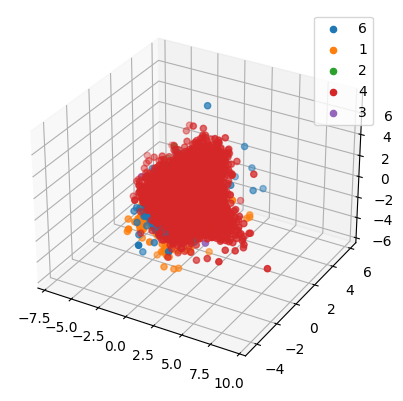

In [138]:
# true clusters
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for label in df_viz.true_label.unique():
        ax.scatter(
            df_viz[df_viz.true_label == label].iloc[:, 0], 
            df_viz[df_viz.true_label == label].iloc[:, 1],
            df_viz[df_viz.true_label == label].iloc[:, 2], 
            label=label
        )
plt.legend()
plt.show()

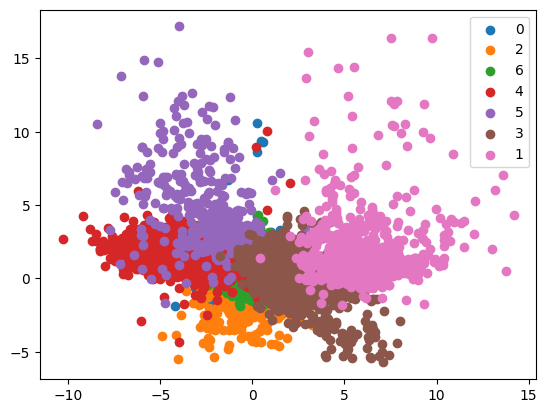

In [129]:
# pred clusters
for label in df_viz.pred_label.unique():
    plt.scatter(
        df_viz[df_viz.pred_label == label].iloc[:, 0], 
        df_viz[df_viz.pred_label == label].iloc[:, 1], 
        label=label
    )
plt.legend()
plt.show()

In [104]:
df_init['activityID'].unique()

NameError: name 'df_init' is not defined